In [1]:
pip install mlflow


   ---------------------------------------- 0.0/20.2 MB ? eta -:--:--
    --------------------------------------- 0.5/20.2 MB 15.2 MB/s eta 0:00:02
   -- ------------------------------------- 1.1/20.2 MB 14.6 MB/s eta 0:00:02
   --- ------------------------------------ 1.8/20.2 MB 14.6 MB/s eta 0:00:02
   --- ------------------------------------ 2.0/20.2 MB 14.2 MB/s eta 0:00:02
   ----- ---------------------------------- 2.6/20.2 MB 12.0 MB/s eta 0:00:02
   ------ --------------------------------- 3.5/20.2 MB 13.2 MB/s eta 0:00:02
   -------- ------------------------------- 4.4/20.2 MB 14.0 MB/s eta 0:00:02
   --------- ------------------------------ 4.8/20.2 MB 13.9 MB/s eta 0:00:02
   ---------- ----------------------------- 5.4/20.2 MB 13.3 MB/s eta 0:00:02
   ------------ --------------------------- 6.2/20.2 MB 13.8 MB/s eta 0:00:02
   ------------- -------------------------- 7.1/20.2 MB 14.1 MB/s eta 0:00:01
   --------------- ------------------------ 7.9/20.2 MB 14.3 MB/s eta 0:

In [2]:
import mlflow
import mlflow.sklearn

#mlflow.set_tracking_uri("file:///mlruns")  # Set this to your MLflow server or leave as default for local tracking


Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,1 hour 39 mins
H2O_cluster_timezone:,America/Toronto
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.1
H2O_cluster_version_age:,1 month and 10 days
H2O_cluster_name:,H2O_from_python_TYS_gefzhk
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.838 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |█
16:55:12.175: Project: AutoML_3_20240423_165512
16:55:12.176: 5-fold cross-validation will be used.
16:55:12.176: Setting stopping tolerance adaptively based on the training frame: 0.028676966733820218
16:55:12.176: Build control seed: 1
16:55:12.177: training frame: Frame key: AutoML_3_20240423_165512_training_py_11_sid_9146    cols: 22    rows: 1216  chunks: 1    size: 208228  checksum: -140458100710306879
16:55:12.177: validation frame: NULL
16:55:12.177: leaderboard frame: NULL
16:55:12.178: blending frame: NULL
16:55:12.178: response column: Order Item Quantity
16:55:12.178: fold column: null
16:55:12.179: weights column: null
16:55:12.180: AutoML: XGBoost is not available; skipping it.
16:55:12.181: Loading execution steps: [{XGBoost : [def_2 (1g, 10w), def_1 (2g, 10w), def_3 (3g, 10w), grid_1 (4g, 90w), lr_search (7g, 30w)]}, {GLM : [def_1 (1g, 10w)]}, {DRF : [def_1

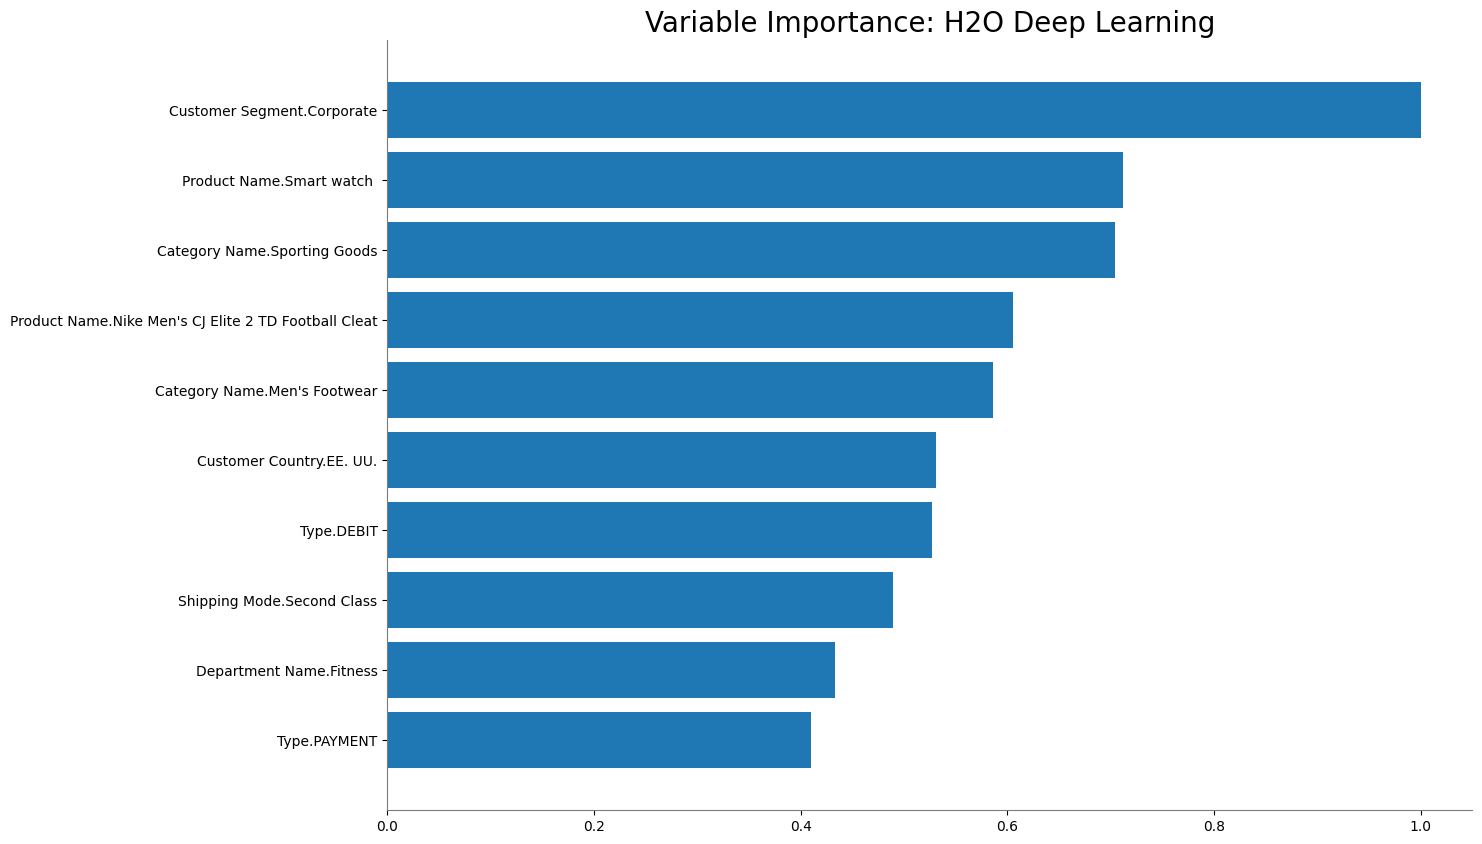

c:\Users\TYS\AppData\Local\Programs\Python\Python311\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


<Figure size 640x480 with 0 Axes>

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import h2o
from h2o.automl import H2OAutoML
import mlflow
import mlflow.h2o

# Initialize H2O
h2o.init()

# Load data
df = pd.read_csv("../data/DataCo_cleaned.csv")

# Split data
train, test = train_test_split(df, test_size=0.4, random_state=42)
test, validation = train_test_split(test, test_size=0.5, random_state=42)

# H2O Frame
hf_dataset = h2o.H2OFrame(df)
train, test = hf_dataset.split_frame(ratios=[0.6], seed=1)
test, val = test.split_frame(ratios=[0.5], seed=1)

# Define the target and features
y = "Order Item Quantity"
X = hf_dataset.columns
X.remove(y)

# Start MLflow experiment
with mlflow.start_run():
    # Configure and run H2O AutoML
    h2o_aml = H2OAutoML(max_models=12, seed=1, exclude_algos=["StackedEnsemble"], verbosity="info")
    h2o_aml.train(x=X, y=y, training_frame=train)

    # Log model
    mlflow.h2o.log_model(h2o_aml.leader, "model")

    # Logging parameters and metrics
    mlflow.log_params({
        "max_models": 12,
        "exclude_algos": "StackedEnsemble",
        "seed": 1
    })

    # Access performance metrics from the leaderboard
    perf = h2o_aml.leader.model_performance(test)
    mlflow.log_metrics({
        "rmse": perf.rmse(),
        "mae": perf.mae(),
        "r2": perf.r2()
    })

    # Variable importance plot
    h2o_aml.leader.varimp_plot()

    # Log the leaderboard
    lb = h2o_aml.leaderboard.as_data_frame()
    lb.to_csv("leaderboard.csv", index=False)
    mlflow.log_artifact("leaderboard.csv")

    # End run
    mlflow.end_run()
